I recently rewatched a [video](https://www.youtube.com/watch?v=Lk6QU94xAb8) from Arthur C. Clarke which is where I
first saw what fractals are. I saw this video while I was in high
school and having rewatched it now I wondered if I can generate the
Mandelbrot set and explore some parts of it myself. I did a quick
search online and I discovered that [Jean Francois Puget](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en) had already
done that and achieved great results. Learning from his work I decided
to do some computational experiments.

For this post I will use the acceleration provided by *numba* as in the
original post by [Jean Francois Puget](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en). In a further post he developed a
parallel version of the code so you can check it out, but for my
purposes now *numba* will be enough.

# Fractals

Fractals are abstract objects that are infinitely complicated and
exhibit similar patterns at increasingly smaller scales. What this
means is that we can keep zooming in the fractal until the original
picture is bigger than the visible universe and still see
patterns. For this post I want to explore the Mandelbrot set and
produce the fractal from it. However, before delving in the Mandelbrot
set we need to look at the more general picture.

The Mandelbrot set is made by iteration using the simple formula
$$z_{n+1} = z_n^2 + c$$ for different values of $c$ in the complex
plane. Then we have two possible paths: the iteration will converge or
diverge. Points on the complex plane $\mathbb{C}$ for which $z_n$ is
bounded form the Mandelbrot set. Points which are not bounded do not
belong to the Mandelbrot set and to get artistic pictures are usually
coloured based on how fast they change. Each point $c$ then specifies
the geometric structure of the corresponding Julia set.

Julia sets are formed by performing a repeated iteration of a
holomorphic function and in this post we will investigate polynomial
functions of the form $z_{n+1} = z_{n}^2 + c$. The set has an
interesting property of chaotic behaviour which produces drastically
different result from a small perturbation. The Julia set also has a
complementary set known as the Fatou set which has the property that
all values behave similarly under the repeated iteration. Now if a
point $c$ is in the Mandelbrot set the Julia set is called connected,
if it is not then it is known as Cantor/Fatou dust.

We can now visualise what we mean by the above by using some Python
code and the Scipy library.

# Mandelbrot Set

The Mandelbrot set is generated using the iterative formula below.

$$z_{n+1} = z_{n}^{2} + c$$

To get the set we start from $z_{0} = 0$ for a given $c$
coordinate. Expressing it mathematically, for a point to belong to the
Mandelbrot set we need the limit to be $\leq 2$. The precise reason is
given below.

$$c \in M \iff \lim_{n \to \infty} \sup|z_{n+1}| \leq 2$$


When I first saw the mathematical description I could not understand
why was the number 2 written as the upper boundary to determine if a
point belongs to the Mandelbrot set or not. I decided to dig further
and I found the mathematical proof. I found the explanation in [Alun
Williams'](http://www.alunw.freeuk.com/mandelbrotroom.html) website and you can read it there.

Lets define the function for the Mandelbrot set.

In [29]:
import numpy as np
from numba import jit

@jit
def mandelbrot(c, maxiter):
    z = c
    
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0

The holomorphic function can then be called to generate the Mandelbrot
set. I will take this opportunity to generalise the set generation and
plot functions so we can use them with the Julia set as well.

In [30]:
@jit
def generate_set(set_function, xmin, xmax, ymin, ymax, width, height, maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    
    for i in range(width):
        for j in range(height):
            n3[i, j] = set_function(r1[i] + 1j * r2[j], maxiter)
    return (r1, r2, n3)

Having generated the set we need a way to visualise it. We can do this
with Matplotlib. As states above the algorithm to display the fractals
is explained [here](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en).

In [31]:
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import patches
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png')

def generate_image(set_function, xmin, xmax, ymin, ymax, width=10, height=10, maxiter=256):
    dpi = 72
    img_width = dpi * width
    img_height = dpi * height
    x,y,z = generate_set(set_function, xmin, xmax, ymin, ymax, img_width, img_height, maxiter)
    
    fig, ax = plt.subplots(figsize=(width, height), dpi=72)
    ticks = np.arange(0, img_width, 3*dpi)
    x_ticks = xmin + (xmax-xmin)*ticks/img_width
    plt.xticks(ticks, x_ticks)
    y_ticks = ymin + (ymax-ymin)*ticks/img_width
    plt.yticks(ticks, y_ticks)
    
    ax.imshow(z.T, origin='lower')

We can then visualise the Mandelbrot set.

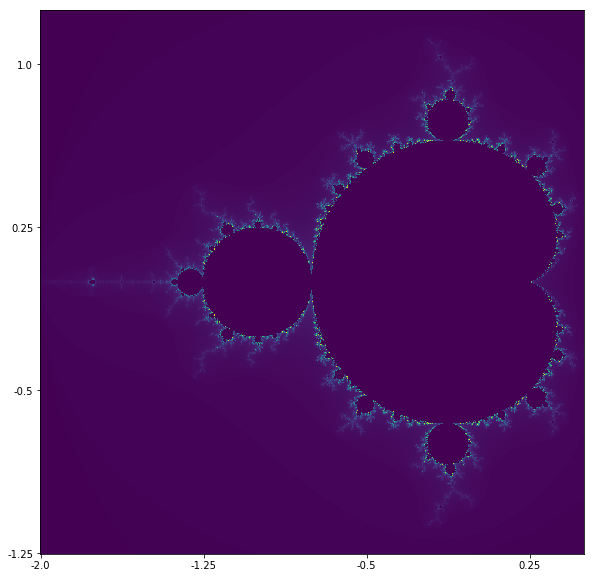

In [32]:
generate_image(mandelbrot, -2.0, 0.5, -1.25, 1.25)

The "main" part of the Mandelbrot is called the main cardioid and the
set contains small copies of itself connected to the main
cardioid. This continues and we get structures which resemble hairs,
not surprisingly these features are called Mandelbrot hair.

Other explorers have discovered interesting anchor points. For example
lets set sail to $-0.761574-i0.0847596$ as shown on maps generated by
[Paul Bourke](http://paulbourke.net/fractals/mandelbrot/). We will centre at this point and zoom $\times 10$ to
start with. Note that the original generated image is of size
$2.5\times2.5$ and we need a function to generate the size of the
image for the given zoom.

In [33]:
def zoom_image(xc, yc, size):
    x1 = xc - size
    x2 = xc + size
    y1 = yc - size
    y2 = yc + size
    return x1, x2, y1, y2

We can than choose our point of interest and zoom into it.

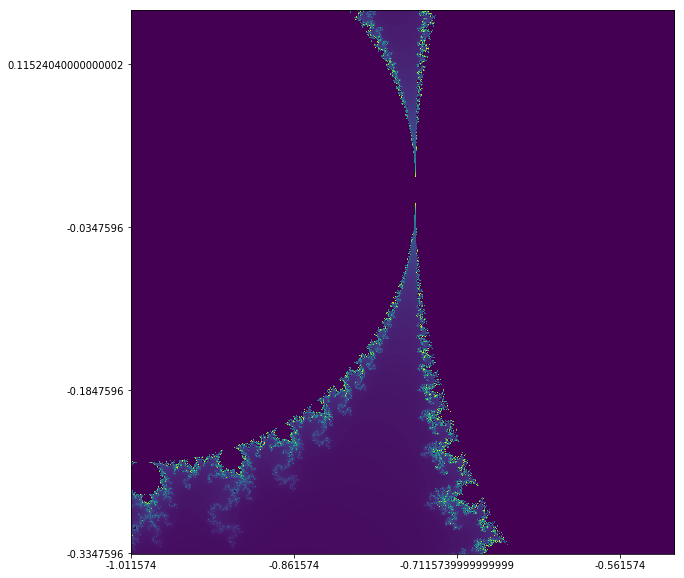

In [34]:
xc = -0.761574
yc = -0.0847596
size = 2.5 / 10

x1, x2, y1, y2 = zoom_image(xc, yc, size)
generate_image(mandelbrot, x1, x2, y1, y2)

Great, everything is looking fine. We can see the primary continental
mu-atom and a mu-atom of period 2, if you want an explanation of the
names go [here](https://www.mrob.com/pub/muency/r2.html). The place in the middle where all the interesting
features occur is know as the [seahorse valley](https://www.mrob.com/pub/muency/seahorsevalley.html) and we are going to
explore the southern part. Lets zoom $\times 500$ and explore the
seahorses.

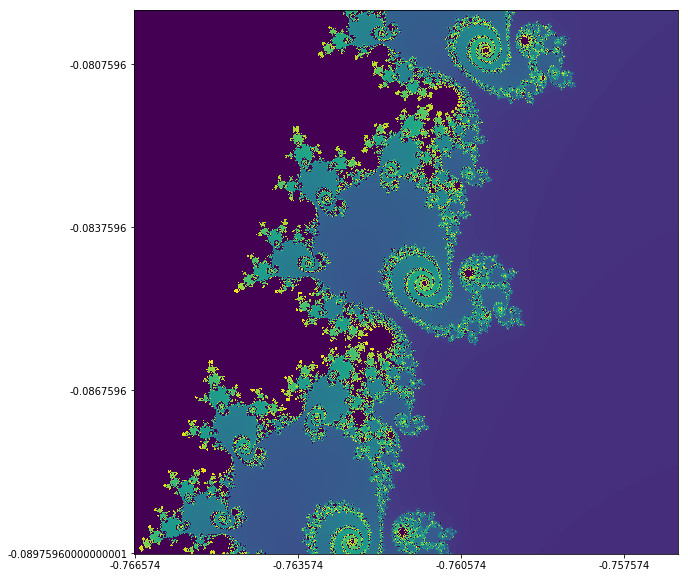

In [35]:
size = 2.5 / 500

x1, x2, y1, y2 = zoom_image(xc, yc, size)
generate_image(mandelbrot, x1, x2, y1, y2)

We can see why mathematicians are referring to these patters as
seahorses. Also notice that more patterns are starting to emerge as we
go deeper in the set. Why stop now, $\times 1000$ it is.

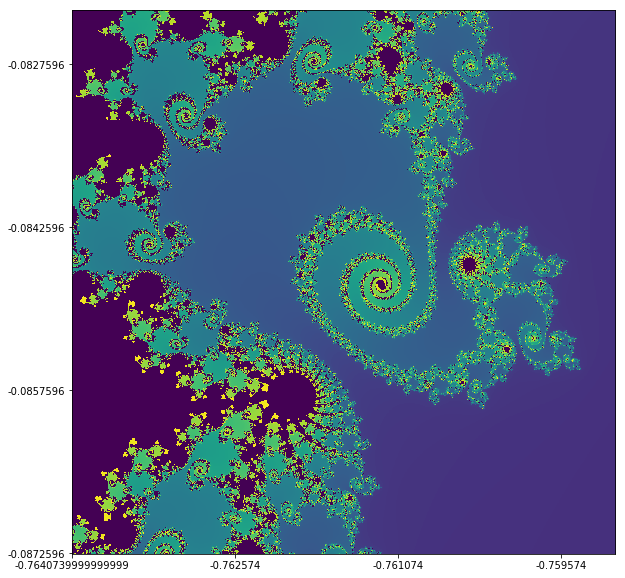

In [36]:
size = 2.5 / 1000

x1, x2, y1, y2 = zoom_image(xc, yc, size)
generate_image(mandelbrot, x1, x2, y1, y2)

I will test the ability of our code to cope with even more decimals
places and zoom to $\times 15625$. We can then compare with the image
obtained from [Paul Bourke](http://paulbourke.net/fractals/mandelbrot/).

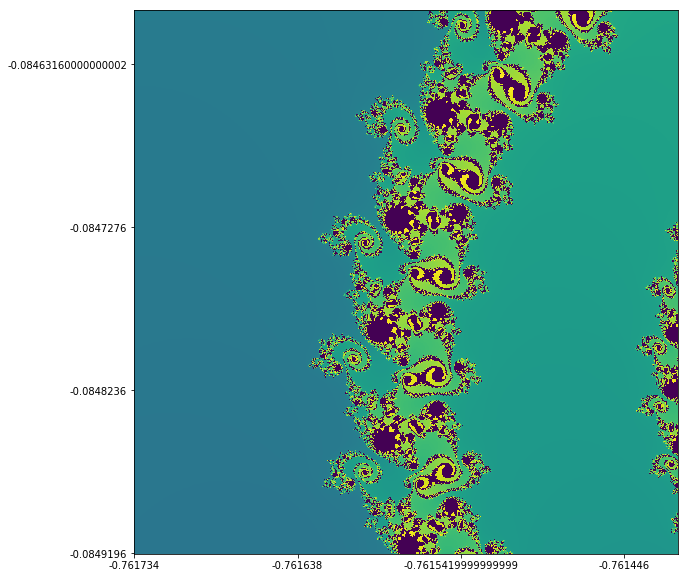

In [37]:
size = 2.5 / 15625

x1, x2, y1, y2 = zoom_image(xc, yc, size)
generate_image(mandelbrot, x1, x2, y1, y2)

Okay, lets go wild and do a $5\times10^6$ zoom.

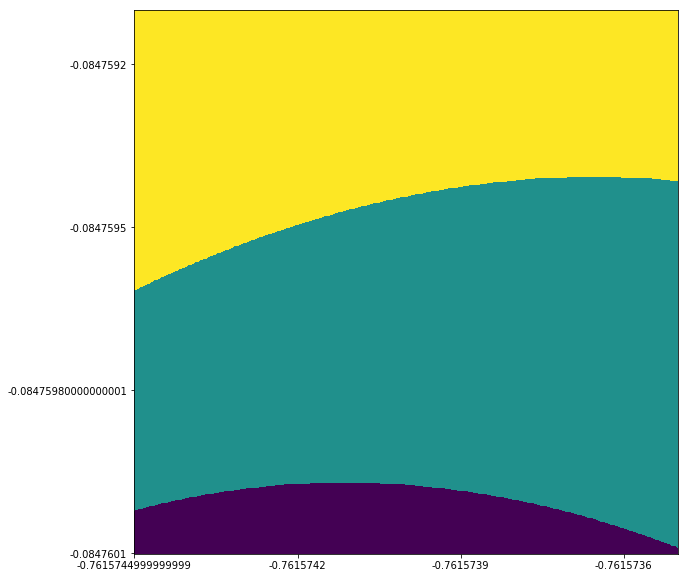

In [38]:
size = 2.5 / (5 * (10**6))

x1, x2, y1, y2 = zoom_image(xc, yc, size)
generate_image(mandelbrot, x1, x2, y1, y2)

Whoops, it seems that we have reached the limit of the colouring
algorithm. This is an issue for another post, where I am planning to
program the problem in C++ and use different generation and colouring
algorithms.

# Julia Set

To generate a Julia set we need a [holomorphic function](https://en.wikipedia.org/wiki/Holomorphic_function). In other words
we need a continuously differentiable complex-valued function with one
or more complex variable. Lets start with something random... the
first thing that comes to mind.

$$f(z) = z^3 + c$$

The iteration is then performed for:

$$z_{n+1} = z_{n}^{3} + c$$

We can then get the points that tend to infinity, those that do not
(Fatou set) and the boundary between them (Julia set) for a complex
number $k$ if we set $c=k$ and start with $z_{0}$ as the coordinates
of a point. Lets explore $c = -0.1 + i0.65$ which is in the Mandelbrot
set and we would get a connected Julia set. The way I have implemented this is to define a holomorphic function
with a given complex parameter $c$, the seemingly weird use of $c$ as
an argument to define $z$ and then be redefined is just for
convenience so I can use the same set generation function as for the
Mandelbrot set.

In [39]:
@jit
def holomorphic_julia(c, maxiter):
    z = c
    c = complex(-0.1, 0.65)
    
    for n in range(maxiter):
        if abs(z) > 10:
            return n
        z = z*z + c
    return 0

We can then show our results and we get a weird looking bulge.

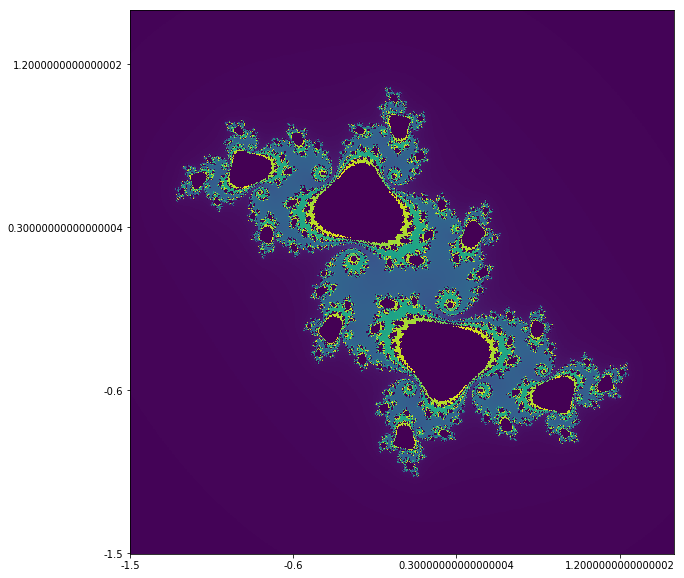

In [40]:
generate_image(holomorphic_julia, -1.5, 1.5, -1.5, 1.5)

Lets examine the fractal nature of this thing we have produced. We
would focus in the middle of our bulge.

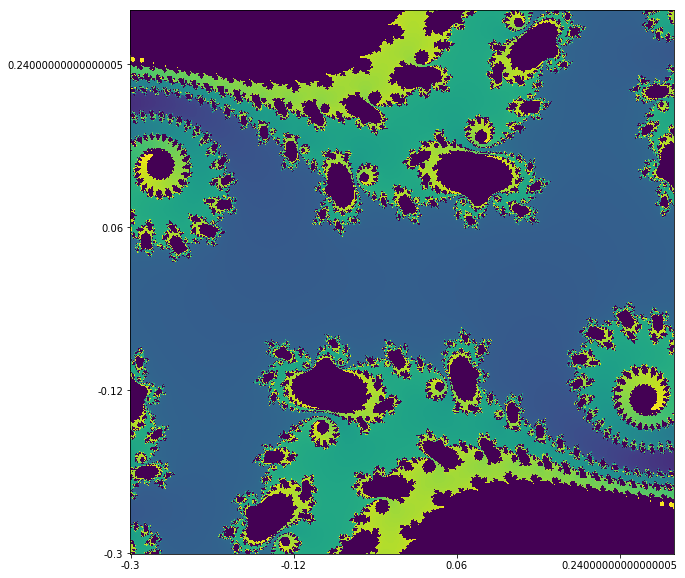

In [41]:
xc = 0.0
yc = 0.0
size = 3.0 / 10

x1, x2, y1, y2 = zoom_image(xc, yc, size)
generate_image(holomorphic_julia, x1, x2, y1, y2)

We can see that we have generated a fractal since zooming in reveals
similar patterns of infinity complexity. We can also see the Julia
set as the boundary between the Fatou sets.

Now we can pick a point which is outside of the Mandelbrot set. Such a
point is $c = -2.5 - i2.5$.

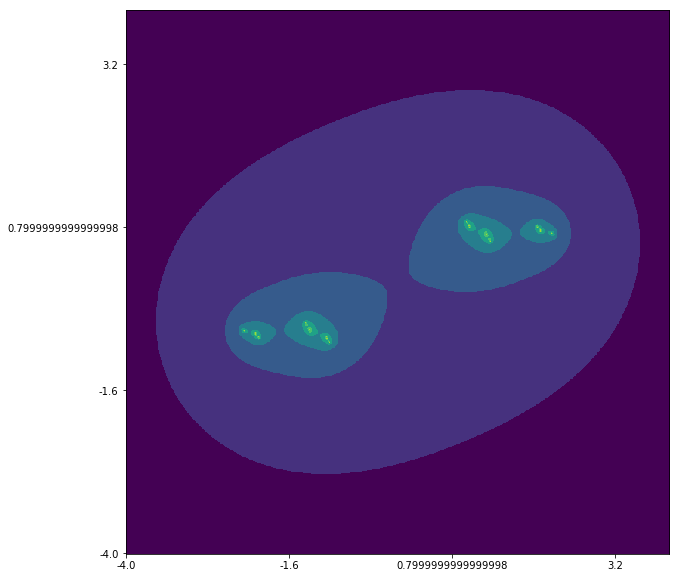

In [42]:
@jit
def holomorphic_candor_dust(c, maxiter):
    z = c
    c = complex(-2.5, -2.5)
    
    for n in range(maxiter):
        if abs(z) > 10:
            return n
        z = z*z + c
    return 0

generate_image(holomorphic_candor_dust, -4.0, 4.0, -4.0, 4.0)

This is known as Cantor/Fatou dust and the calculation oscillates
between the points on the plot which is very different from the
previous Julia set. As can be seen the resultant behaviour is very
much dependent on whether $c$ is in the Mandelbrot set or not.  We can
also investigate different complex parameters. For example lets see a
$c = -0.78 + 0.1i$ which is in the Mandelbrot set and the function
$z_{n+1} = z_{n}^{2} + c$ as shown [here](https://ibmathsresources.com/2015/03/29/mandelbrot-and-julia-sets-pictures-of-infinity/).

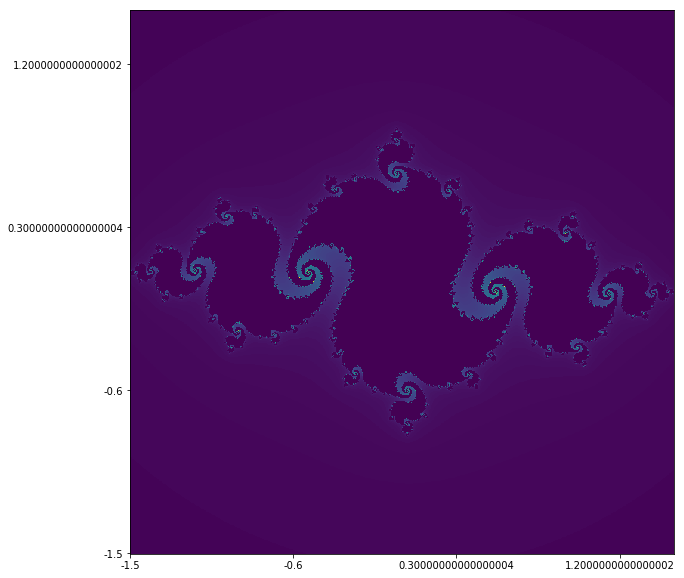

In [43]:
@jit
def holomorphic_julia_spinning_eyes(c, maxiter):
    z = c
    c = complex(-0.78, 0.1)
    
    for n in range(maxiter):
        if abs(z) > 10:
            return n
        z = z*z + c
    return 0

generate_image(holomorphic_julia_spinning_eyes,  -1.5, 1.5, -1.5, 1.5)

Thank you for reading!!! I hope this was a fun post.